# Notebook to make plots of wingbeat frequency vs spike rate

## Imports

In [1]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
from mosquito.process_abf import load_processed_data, detrend_emg
from mosquito.util import set_plot_params, my_adjust_axes, my_add_scalebar


## Helper functions

In [123]:
# def my_adjust_axes(ax, keep_spines=['left', 'bottom'], xticks=None, yticks=None,
#                    offset_length=10, tick_length=5, trim_ticks_flag=True):
#     """
#     Convenience function to adjust axes to match plotting style

#     Borrows heavily from flyplotlib:
#     https://github.com/florisvb/FlyPlotLib/

#     Args:
#         ax: matplotlib axis object
#         keep_spines: list of spines to keep
#         xticks: array containing x tick mark locations
#         yticks: array containing y tick mark locations
#         offset_length: amount to offset axis rulers by
#         tick_length: length to set axis ticks to
#         timr_ticks_flag: bool, should we try to reduce tick count?

#     Returns:
#         ax: matplotlib axis object

#     TODO: 
#         - allow different offsets for each spine
#     """
#     # make sure keep_spines is a list
#     if type(keep_spines) is not list:
#         keep_spines = [keep_spines]

#     # check if we should remove all axes and just return
#     if 'none' in keep_spines:
#         for loc, spine in ax.spines.items():
#             spine.set_color('none') # don't draw spine
#         ax.yaxis.set_ticks([])
#         ax.xaxis.set_ticks([])
#         return ax
        
#     # get ticks
#     if xticks is None:
#         xticks = ax.get_xticks()
#     elif not isinstance(xticks,np.ndarray):
#         xticks = np.asarray(xticks)
    
#     if yticks is None:
#         yticks = ax.get_yticks()
#     elif not isinstance(yticks,np.ndarray):
#         yticks = np.asarray(yticks)
    
#     # sometimes we get ticks outside of limits that confuse the issue--remove
#     xlim = ax.get_xlim()
#     xticks = xticks[(xticks >= xlim[0]) & (xticks <= xlim[1])]
#     ylim = ax.get_ylim()
#     yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]
    
#     # get spines from axis object
#     spines = ax.spines
#     spine_locs = [loc for loc in spines.keys()]

#     # remove spines that we don't want
#     rm_spines = [loc for loc in spine_locs if loc not in keep_spines]
#     for loc in rm_spines:
#         ax.spines[loc].set_visible(False)

#     # turn off ticks where there is no spine
#     if 'left' in keep_spines:
#         ax.yaxis.set_ticks_position('left')
#     elif 'right' in keep_spines:
#         ax.yaxis.set_ticks_position('right')
#     else:
#         # no yaxis ticks
#         ax.yaxis.set_ticks([])

#     if 'bottom' in keep_spines:
#         ax.xaxis.set_ticks_position('bottom')
#     if 'top' in keep_spines:
#         ax.xaxis.set_ticks_position('top')
#     else:
#         # no xaxis ticks
#         ax.xaxis.set_ticks([])    

#     # for spines we want to keep, offset them
#     for loc in keep_spines:
#         # move spines outward
#         ax.spines[loc].set_position(('outward', 15))

#         # adjust spine size based on tick lengths
#         if loc in ['left', 'right']:
#             ticks = yticks
#         if loc in ['top', 'bottom']:
#             ticks = xticks
#         if ticks is not None and len(ticks) > 0:
#             ax.spines[loc].set_bounds(ticks[0], ticks[-1])

#         # trim ticks down to minimum?
#         if trim_ticks_flag:
#             # take only ticks at limits or ticks at limits + middle
#             if (ticks.size > 3) & (ticks.size%2 == 1):
#                 ticks = ticks[[0, int(np.floor(xticks.size/2)), -1]]
#             elif (ticks.size > 3) & (ticks.size%2 == 0):
#                 ticks = ticks[[0, -1]]

#             # update tick values in axis
#             if loc in ['left', 'right']:
#                 ax.yaxis.set_ticks(ticks)
#             if loc in ['top', 'bottom']:
#                 ax.xaxis.set_ticks(ticks)

#     # also just set ticks inward
#     ax.tick_params(direction='in', length=tick_length)
    
#     # return
#     return ax

In [157]:
# def my_add_scalebar(ax, scalebar_bounds, linewidth=1.5, spine='bottom', units='', ticklength=0, 
#                     offset_length=10):
#     """
#     Function to convert an axis spine into a scalebar 

#     Args:
#         ax: matplotlib axis object
#         scalebar_bounds: 2 element tuple giving start and end of scalebar
#         linewidth: width of scalebar
#         spine: which spine to turn into scalebar
#         units: string giving units of scalebar
#         ticklength: length of ticks to use for scalebar

#     Returns:
#         ax
#     """
#     # set spine to be visible 
#     ax.spines[spine].set_visible(True)
#     # reduce its length
#     ax.spines[spine].set_bounds([scalebar_bounds[0], scalebar_bounds[1]])
#     # set thickness
#     ax.spines[spine].set_linewidth(linewidth)
#     # move outward
#     ax.spines[spine].set_position(('outward', offset_length))
    
#     # label scalebar
#     scalebar_center = (scalebar_bounds[0] + scalebar_bounds[1])/2
#     scalebar_size = scalebar_bounds[1] - scalebar_bounds[0]
#     if spine in ['bottom', 'top']:
#         ax.set_xticks([scalebar_center])
#         ax.set_xticklabels([f'{scalebar_size} {units}'])
#         ax.tick_params(axis='x', length=ticklength)
#     elif spine in ['left', 'right']:
#         ax.set_yticks([scalebar_center])
#         ax.set_yticklabels([f'{scalebar_size} {units}'])
#         ax.tick_params(axis='y', length=ticklength)

#     # return 
#     return ax


## Params

In [124]:
# plot parameters
plot_type = 'poster'  # 'paper' or 'powerpoint' or 'poster
plot_params = set_plot_params(plot_type=plot_type)


In [125]:
# save info 
save_path = '/media/sam/SamData/Dropbox/Conferences/ICN 2024/poster/figs'
save_str = 'wbf_vs_spike_rate'
save_str_corr = 'wbf_spike_rate_corr'
save_flag = True
save_dpi = 500

In [126]:
# example fly
data_folder_ex = 22
axo_num_ex = 12

In [127]:
# plot options
bin_flag = False

ms = 14
alpha = 0.8

scatter_ms = 10
scatter_alpha = 0.35

mosquito_female_color = '#004488'
mosquito_male_color = '#BB5566'
drosophila_color = '#555555'
colors = [mosquito_female_color , mosquito_male_color , drosophila_color]
species_list = ['Aedes', 'Aedes', 'Drosophila']
sex_list = ['F', 'M', 'F']


## Load data

In [71]:
# path to pandas dataframe
data_path = '/media/sam/SamData/Mosquitoes/analysis'
if bin_flag:
    data_fn = 'spike_rate_wbf_data_binned.pkl'
else:
    data_fn = 'spike_rate_wbf_data.pkl'

fly_df = pd.read_pickle(os.path.join(data_path, data_fn))

## Make figure

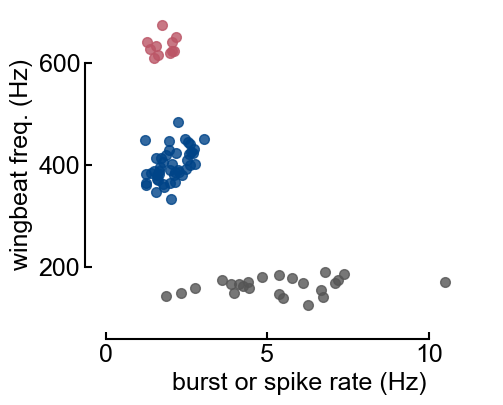

In [72]:
# quick plot
fig, ax = plt.subplots(figsize=(5,4))

# loop over species and sex
for ith, (spec, sx) in enumerate(zip(species_list, sex_list)):
    # get index matching current dataset
    idx = (fly_df['species'] == spec) & (fly_df['sex'] == sx)
    
    # get data
    if bin_flag:
        x = fly_df['spike_rate'][idx]
        y = fly_df['wbf'][idx]
    else:
        x = fly_df['spike_rate_mean'][idx]
        y = fly_df['wbf_mean'][idx]

    # plot
    ax.plot(x, y, '.', ms=ms, alpha=alpha, color=colors[ith], label=f'{spec} {sx}')

# label axes
ax.set_xlabel('burst or spike rate (Hz)')
ax.set_ylabel('wingbeat freq. (Hz)')

# axis limits
ax.set_xlim([0, 12])
ax.set_ylim([100, 705])

ax = my_adjust_axes(ax)

if save_flag:
    fig.savefig(os.path.join(save_path, f'{save_str}.svg'), dpi=save_dpi, bbox_inches='tight')


## Make plot for correlation between wbf and spike rate

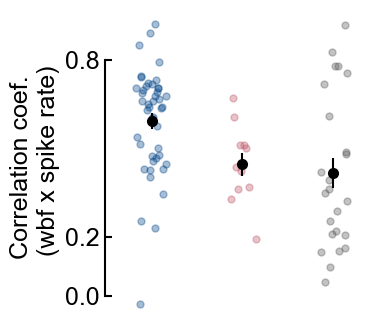

In [111]:
# make plot
fig, ax = plt.subplots(figsize=(3.0, 4))

# loop over species and sex
for ith, (spec, sx) in enumerate(zip(species_list, sex_list)):
    # get index matching current dataset
    idx = (fly_df['species'] == spec) & (fly_df['sex'] == sx)
    
    # get correlation vals
    Rvals = fly_df['R'][idx]

    # plot data
    jitter_vals = 0.35*(np.random.rand(Rvals.shape[0]) - 0.5)
    ax.plot(ith*np.ones_like(Rvals) + jitter_vals, Rvals, '.', ms=scatter_ms, alpha=scatter_alpha, 
            color=colors[ith], label=f'{spec} {sx}')

    # plot mean +/- std
    R_mean = np.mean(Rvals)
    R_std = np.std(Rvals)
    R_se = R_std/np.sqrt(Rvals.size)
    ax.errorbar(ith, R_mean, yerr=R_se, ecolor='k', fmt='o', color='k', ms=ms/2)

# label axes
ax.set_ylabel('Correlation coef. \n (wbf x spike rate)')

# # axis limits
# ax.set_xlim([0, 12])
# ax.set_ylim([100, 705])

ax = my_adjust_axes(ax, keep_spines=['left'])
# # axis spines

if save_flag:
    fig.savefig(os.path.join(save_path, f'{save_str_corr}.svg'), dpi=save_dpi, bbox_inches='tight')

## Also make plots of wbf and spike rate in a single fly

In [128]:
# load dataset for example fly
data = load_processed_data(data_folder_ex, axo_num_ex)


In [129]:
# read out data for example fly
t = data['time']
wbf = data['wbf']
emg = data['emg']
burst_rate = data['spike_rate']

emg = detrend_emg(emg)

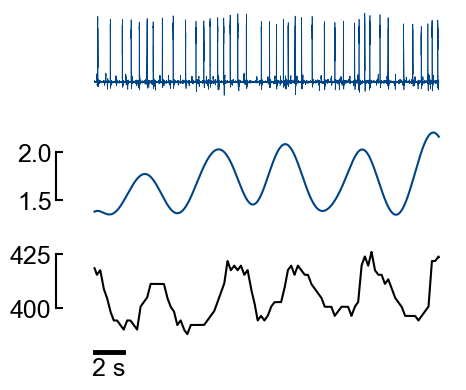

In [158]:
# plot 
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(5, 4.25))

# restrict x range
tmin = 1
tmax = 25
mask = (t >= tmin) & (t <= tmax)


# plot spikes
ax0.plot(t[mask] - tmin, emg[mask], color=mosquito_female_color, lw=0.5)
ax0 = my_adjust_axes(ax0, keep_spines=['none'])

ax1.plot(t[mask] - tmin, burst_rate[mask], color=mosquito_female_color, lw=1.5)
# ax1.set_ylabel('spike rate (Hz)')
ax1 = my_adjust_axes(ax1, keep_spines=['left'])

# plot wbf
ax2.plot(t[mask] - tmin, wbf[mask], color='k', lw=1.5)
# ax2.set_ylabel('wbf (Hz)')
ax2 = my_adjust_axes(ax2, keep_spines=['left'])

# add scalebar
ax2 = my_add_scalebar(ax2, scalebar_bounds=(0, 2), linewidth=3.5, units='s') 

fig.tight_layout()

if save_flag:
    fig.savefig(os.path.join(save_path, f'{save_str_corr}_ex.svg'), dpi=save_dpi, bbox_inches='tight')

In [64]:
R = np.corrcoef(burst_rate, wbf)
R

array([[1.    , 0.3336],
       [0.3336, 1.    ]])

In [37]:
for key in ax.spines.keys():
    print(key)

left
right
bottom
top


In [38]:
ax.xaxis.get_label_position()

'bottom'